In [1]:
import numpy as np 
import os
import re
from tqdm import tnrange
import matplotlib.pyplot as plt

In [2]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def calc_hamming_weight(n):
    return bin(n).count("1")

sbox_2d = np.reshape(sbox, (16, 16))

N=256 

bit_vals=np.arange(0,256)
HW=[calc_hamming_weight(k) for k in bit_vals]


def int_2_hex_string(input):
    return (("0x%0.2X" % input).split('x')[-1])

def sub_bytes(next):
    s_next = int_2_hex_string(next)
    return (sbox_2d[int(s_next[1],16)][int(s_next[0],16)])


def add_round_key(key, next):
    return (key ^ next)


def forward_lookup(next, key):
    return(add_round_key(sub_bytes(next), key))


def generate_loopup_table():
    lookup_table = np.zeros((N,N))
    for ct_prev in range(N):
        for key in range(N):
            lookup_table[ct_prev,key] = forward_lookup(ct_prev, key)

    return lookup_table.astype(int)


def inverse_lookup(key_8, ct_8):
    global lookup_table
    column = lookup_table[:, key_8]

    return np.where(column == ct_8)[0][0]


def get_unarranged_prev_ct(key, ct):
    prev_ct_arr_unarranged = []
    for i in range(16):
        key_8_int = int( (key[i*2: (i*2)+2]) , 16 )
        ct_8_int  = int( (ct[i*2: (i*2)+2]) , 16 )
        prev_ct_arr_unarranged.append( int_2_hex_string( inverse_lookup(key_8_int, ct_8_int) )[::-1] )

    return prev_ct_arr_unarranged


def get_mapping():
    key     = 'd014f9a8c9ee2589e13f0cc8b6630ca6'
    ct      = '3ad77bb40d7a3660a89ecaf32466ef97'
    prev_ct = 'bb36c7eb88334d49a4e7112e74f182c4'

    prev_ct_arr_unarranged  = get_unarranged_prev_ct(key, ct)
    prev_ct_arr_arranged    = re.findall('..',prev_ct.upper())

    mapping = []
    
    for i in range(16):
        mapping.append(prev_ct_arr_arranged.index(prev_ct_arr_unarranged[i]))
    return mapping


def rearrange_prev_ct(unarranged):
    mapping = get_mapping()
    arranged = ""

    for i in range(16):
        arranged = arranged + unarranged[mapping.index(i)]

    return arranged

In [10]:
def getCipher(dir="Simulations/ct"):

    line =[]
    cypher=[]
    names=[]

    directory = os.fsencode(dir)

    for file in os.listdir(directory):

        filename = os.fsdecode(file)

        with open(os.path.join(dir,filename),'r') as f:
            names.append(filename)
            line=(f.readlines()) #loading cypher
            cypher.append(line)
        
    cypher_floats=[]
    for k in cypher:
        container=[]
        for j in k:
            temp=j.strip()
            temp2="0x"+temp
            temp3=int(temp2,16)
            container.append(temp3)
        cypher_floats.append(container)
                
    return names,cypher_floats

def get_load_order(names_list):
    order=[]
    for k in names_list:
        order.append(int((k.split(".")[0]).split("_")[-1]))
    return order

def getPower(dir_="Simulations/power"):
    power_file=[]
    power=[]
    names=[]

    directory = os.fsencode(dir_)

    for file in os.listdir(directory):

        filename = os.fsdecode(file)

        if filename.endswith("txt"):
            names.append(filename)
            with open(os.path.join(dir_,filename),'r') as f:
                power_file=(f.readlines()) #loading power
                power.append(power_file)
    
    power_floats=[]
    for k in power:
        container=[]
        for j in k:
            temp=j.strip()
            temp2=float(temp)
            container.append(temp2)
        power_floats.append(container)

    return names,power_floats

def get_r10_keys(dir_="../Simulations/"):
    keys=[]
    keys_final=[]

    directory = os.fsencode(dir_)

    for file in os.listdir(dir_):

        filename = os.fsdecode(file)

        if filename.endswith("round10_key.txt"):
            with open(os.path.join(dir_,filename),'r') as f:
                key_line=(f.readlines()) #loading power
                keys.append(key_line)
    keys=keys[0]
    
    for k in keys: 
        temp0=k.split(" ")[-1]
        temp=temp0.strip()
        temp2="0x"+temp
        temp3=int(temp2,16)
        keys_final.append(temp3)
        
    return keys_final

def int_2_hex_string(input):
    return (("0x%0.2X" % input).split('x')[-1])

### Getting CT

In [11]:
cipher_names,ciphers=getCipher("../Simulations/ct")

print(get_load_order(cipher_names))

[1, 10, 100, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


### Getting Power

In [12]:
power_names,power_traces=getPower("../Simulations/power")
# print(len(power_names),len(power_traces))
print(get_load_order(power_names))
print(power_traces[3][3516])


[1, 10, 100, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
0.0003211


No handles with labels found to put in legend.


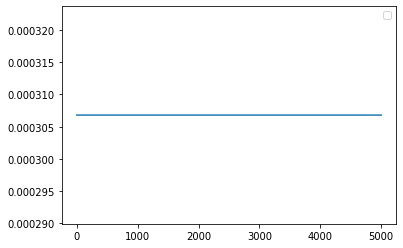

In [13]:
plt.plot(power_traces[53])
plt.legend()

### Getting the Keys



In [7]:
r10_keys = get_r10_keys()
# for k in r10_keys:
#     print(int_2_hex_string(k))
print(int_2_hex_string(r10_keys[6]))

8FFCE27E4C09DB94FC23C089D313DA51


### Reordering to match

We know that the cipher and power are in matched order, the keys are not as they are list in the text file from 0 to 100. Therefore an ordering is in place. 

In [8]:
#get order in terms of indeces
order=[k-1 for k in get_load_order(cipher_names)]
print(order)

#reordering the keys
r10_keys=[r10_keys[i] for i in order]
print(int_2_hex_string(r10_keys[1]))

[0, 9, 99, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 6, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 7, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 8, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
3E6F2C4C943A4A246D9026EA20A2C34D


### Now that we have verified all the handling functions work and everything is ordered to match by index,

We can move one to the correlation analysis. First, we find the previous cipher texts

In [9]:
lookup_table=generate_loopup_table()

print("key  ", hex(r10_keys[0]).split("x")[-1])
print("Cipher ", hex(ciphers[0][0]).split("x")[-1])

prev_ciphers=np.empty(shape=(100,5000),dtype=object)

print(int('CB129DA1698005C36666994F2D8585E9',16))

for i in range(len(ciphers)):
    for j in range(len(ciphers[i])):
        temp_key=hex(r10_keys[0]).split("x")[-1]
        temp_ct=hex(ciphers[0][0]).split("x")[-1]
        unarranged=get_unarranged_prev_ct(temp_key,temp_ct)
        prev_ciphers[i][j]=int(rearrange_prev_ct(unarranged),16)


key   b4ef5bcb3e92e21123e951cf6f8f188e
Cipher  ab22b5d5c7a17523107e0fe1b746730a
269929941614484182958079461526755182057


KeyboardInterrupt: 

In [ ]:
print(prev_ciphers.shape)
print(prev_ciphers[0,0])

(100, 5000)
269929941614484182958079461526755182057


## CPA

The actual algorithm is as follows for datasets $X$ and $Y$ of length $N$, with means of $\bar{X}$ and $\bar{Y}$, respectively:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

$cov(X, Y)$ is the covariance of `X` and `Y` and can be calculated as follows:

$$cov(X, Y) = \sum_{n=1}^{N}[(Y_n - \bar{Y})(X_n - \bar{X})]$$

$\sigma_X$ and $\sigma_Y$ are the standard deviation of the two datasets. This value can be calculated with the following equation:

$$\sigma_X = \sqrt{\sum_{n=1}^{N}(X_n - \bar{X})^2}$$



In [ ]:
def mean(X):
    return np.mean(X,axis=0)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2,axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar),axis=0)

Testing the HW weight functions

In [ ]:
print(calc_hamming_weight(56))
print(bin(56))
print(HW[int("0xff",16)])
print(len(ciphers),len(ciphers[0]))

3
0b111000
8
100 5000


### Generate Hamming Distances between the cipher and the previous cipher

In [ ]:
ciphers_r10=np.array(ciphers) #converted to numpy array to make calculation easier
prev_ciphers=prev_ciphers.astype(object) 

print(ciphers_r10.shape, prev_ciphers.shape)
H_distances=np.empty((ciphers_r10.shape[0],ciphers_r10.shape[1]),dtype=object)
print(H_distances.shape)
print((ciphers_r10[3,0]))
print((prev_ciphers[0,0]))
print((prev_ciphers[0,0]^ciphers_r10[0][0]))
print(calc_hamming_weight(prev_ciphers[0,0]^ciphers_r10[0][0]))


for i in range(len(ciphers)):
    for j in range(len(ciphers[i])):
        distance=prev_ciphers[i,j]^ciphers_r10[i,j]
        H_distances[i,j]=calc_hamming_weight(distance)

print(H_distances.shape)

        

(100, 5000) (100, 5000)
(100, 5000)
148600106302996183445280201292192070955
269929941614484182958079461526755182057
127855938385303412553002856156527589091
58
(100, 5000)


In [ ]:
t_bar = np.sum(power_traces, axis=0)/len(power_traces)   #mean
o_t = np.sqrt(np.sum((power_traces - t_bar)**2, axis=0)) #st_dev

bestguess = [0] * 16 #key byte guesses here
corr_total=[]

for bnum in tnrange(0, 16):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
        
        #Repeating the key byte guessing process from the last loop
        hws = np.array([[HW[textin[bnum]] for textin in H_distances]]).transpose()
        hws_bar=mean(hws)
        o_hws=std_dev(hws,hws_bar)
        cpaoutput = (cov(hws,hws_bar,power_traces,t_bar))/(o_t*o_hws)
        maxcpa[kguess] = cpaoutput
        
        #Get the highes correlation
        correlations=[np.max(np.abs(k)) for k in maxcpa]
        guess=np.argmax(correlations)
        corr_total.append(correlations)

        #store the bytes
        bestguess[bnum]= guess

        
print("Best Key Guess: ", end="")
for b in bestguess: print("%02x " % b, end="")
print(len(bestguess))

C:\Users\ub352\AppData\Local\Temp/ipykernel_28972/1760216742.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for bnum in tnrange(0, 16):


  0%|          | 0/16 [00:00<?, ?it/s]

Best Key Guess: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 16


### CORRELATIONS are too low!

0.2340823166376791


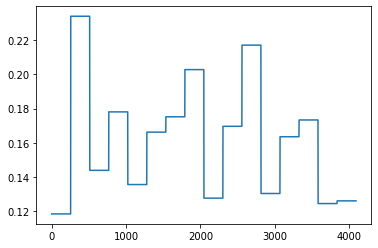

In [ ]:
maxes=[]
for k in corr_total:
    maxes.append(max(k))
plt.plot(maxes)
print(np.max(maxes))